# Homework 03
## Keith Wampler
#### AI Tool Used: Gemini 2.5 Pro 

Homework - Principal Component Analysis
The CDC Social Vulnerability Index (SVI) takes multiple differen population-level inputs (e.g., % of the population living in poverty, % of the population without health insurance) to identify particularly vulnerable counties. While the CDC SVI scores rely on adding up the percentiles of various characteristics, there are alternative indexes (e.g., University of South Carolina SoVI index) that use methods like PCA. Here, we are going to use the CDC SVI data to create an alternative index based on PCA.

1. The following variables are used in the SVI: 

EP_POV150, EP_UNEMP, EP_HBURD, EP_NOHSDP, EP_UNINSUR, EP_AGE65, EP_AGE17, EP_DISABL, EP_SNGPNT, EP_LIMENG, EP_MINRTY, EP_MUNIT, EP_MOBILE, EP_CROWD, EP_NOVEH, EP_GROUPQ, EP_NOINT

a. Subset the merged dataset to only include the variables above and look at the pattern of missing data. Are missing observations scattered throughout the data or are entire rows or columns missing?

## Data Loading

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

DATA_CSV = "/Users/keith/Documents/code/Intro to ML 2025/data/processed/processed_data.csv"
df = pd.read_csv(DATA_CSV, low_memory=False)

SVI_VARS = [
    "EP_POV150","EP_UNEMP","EP_HBURD","EP_NOHSDP","EP_UNINSUR","EP_AGE65","EP_AGE17",
    "EP_DISABL","EP_SNGPNT","EP_LIMENG","EP_MINRTY","EP_MUNIT","EP_MOBILE","EP_CROWD",
    "EP_NOVEH","EP_GROUPQ","EP_NOINT"
]

ID_COLS = [c for c in ["FIPS","STATE_x","COUNTY_x","NRI_ID"] if c in df.columns]
svi = df[ID_COLS + SVI_VARS] if ID_COLS else df[SVI_VARS]
svi.head()


,FIPS,STATE_x,COUNTY_x,NRI_ID,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,...,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,EP_NOINT
0,1001,Alabama,Autauga,C01001,20.2,2.8,19.7,9.6,7.4,15.6,...,16.4,5.6,0.4,27.4,3.9,15.6,1.4,4.0,0.9,10.9
1,1003,Alabama,Baldwin,C01003,18.3,3.4,23.2,8.4,9.3,21.2,...,13.9,4.2,0.8,17.7,16.6,10.2,1.9,2.3,1.5,10.9
2,1005,Alabama,Barbour,C01005,37.7,5.8,25.1,23.5,10.7,19.8,...,18.1,11.3,2.0,55.4,1.4,29.2,3.8,11.7,12.0,31.8
3,1007,Alabama,Bibb,C01007,29.0,8.7,23.2,21.1,8.4,16.8,...,19.6,7.2,0.3,25.8,2.7,30.6,1.3,7.5,6.4,20.2
4,1009,Alabama,Blount,C01009,22.9,6.0,19.4,18.2,10.2,18.3,...,17.0,5.3,2.2,14.3,0.9,23.9,2.3,4.8,1.0,16.9


## Missing Data

In [15]:
miss_by_col = svi[SVI_VARS].isna().sum().sort_values(ascending=False)
rows_with_any_na = svi[SVI_VARS].isna().any(axis=1).sum()
rows_with_all_na = svi[SVI_VARS].isna().all(axis=1).sum()

print(f"Rows: {len(svi)}")
print(f"Columns: {len(SVI_VARS)}")
print(f"Rows with ANY NA: {rows_with_any_na} ({rows_with_any_na/len(svi):.2%})")
print(f"Rows with ALL NA: {rows_with_all_na} ({rows_with_all_na/len(svi):.2%})")

miss_by_col


Rows: 3240
Columns: 17
Rows with ANY NA: 96 (2.96%)
Rows with ALL NA: 96 (2.96%)


EP_POV150     96
EP_LIMENG     96
EP_GROUPQ     96
EP_NOVEH      96
EP_CROWD      96
EP_MOBILE     96
EP_MUNIT      96
EP_MINRTY     96
EP_SNGPNT     96
EP_UNEMP      96
EP_DISABL     96
EP_AGE17      96
EP_AGE65      96
EP_UNINSUR    96
EP_NOHSDP     96
EP_HBURD      96
EP_NOINT      96
dtype: int64

b. PCA cannot handle missing values by default. There are several options for handling missing data generally, including imputation, removing rows with missing data, or removing columns with missing data. Deal with the missing data in a way that makes sense for the pattern of missing data and the goals of the analysis. Explain why you made this decision. Note: How you handle this is specific to the missing data pattern and the goals of the analysis. For example, when entire rows or columns are missing, imputation may not be appropriate and dropping those rows or columns is usually the best option. Conversely, if you have a general missingness pattern where missing observations are scattered throughout the data, imputation is likely the best option.

## Imputation

In [16]:
#removes rows that are completely empty in the SVI_VARS columns, and then fills any remaining scattered missing values in those columns using the median

mask_all_missing = svi[SVI_VARS].isna().all(axis=1)
svi_clean = svi.loc[~mask_all_missing].copy()

if svi_clean[SVI_VARS].isna().any().any():
    imputer = SimpleImputer(strategy="median")
    svi_imputed = pd.DataFrame(imputer.fit_transform(svi_clean[SVI_VARS]),
                               columns=SVI_VARS, index=svi_clean.index)
else:
    svi_imputed = svi_clean[SVI_VARS].copy()

print(f"Dropped {mask_all_missing.sum()} rows (all SVI missing)")
svi_imputed.describe().T


Dropped 96 rows (all SVI missing)


,count,mean,std,min,25%,50%,75%,max
EP_POV150,3144.0,23.954580,8.394533,2.6,18.0,23.00,28.900,66.6
EP_UNEMP,3144.0,4.951336,2.474412,0.0,3.4,4.70,6.000,32.0
EP_HBURD,3144.0,21.855153,5.087702,0.0,18.6,21.55,24.900,48.5
EP_NOHSDP,3144.0,11.646406,5.718239,0.3,7.5,10.45,14.700,66.7
EP_UNINSUR,3144.0,9.512945,5.081359,0.0,5.8,8.40,12.000,45.1
EP_AGE65,3144.0,19.703753,4.842100,2.9,16.6,19.30,22.200,57.9
EP_AGE17,3144.0,21.896724,3.537931,0.0,19.8,21.90,23.800,41.2
EP_DISABL,3144.0,16.185305,4.544692,4.5,12.9,15.70,18.900,41.2
EP_SNGPNT,3144.0,5.734606,2.421851,0.0,4.2,5.40,7.000,20.3
EP_LIMENG,3144.0,1.589440,2.635562,0.0,0.3,0.70,1.700,36.4


Median imputation was selected to handle scattered missing values in the dataset. This method was chosen because it helps preserve the data's distribution and minimizes the influence of outliers, which is crucial for preparing the data for the outlier-sensitive PCA.

## Run PCA

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(svi_imputed)

pca = PCA(n_components=len(SVI_VARS), random_state=42)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained))],
    "Explained_Var": explained,
    "Cumulative": cum_explained
}).head(10)


,PC,Explained_Var,Cumulative
0,PC1,0.282259,0.282259
1,PC2,0.191706,0.473965
2,PC3,0.108279,0.582244
3,PC4,0.068032,0.650275
4,PC5,0.059289,0.709564
5,PC6,0.057202,0.766767
6,PC7,0.036447,0.803213
7,PC8,0.034255,0.837468
8,PC9,0.029524,0.866992
9,PC10,0.026252,0.893244


## PC Scree Plot

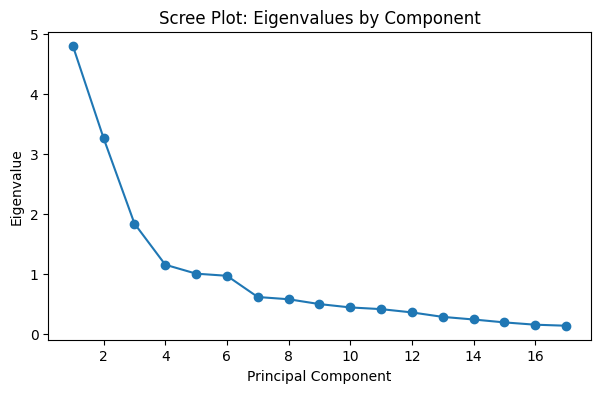

In [18]:
plt.figure(figsize=(7,4))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.title("Scree Plot: Eigenvalues by Component")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.show()


## PCs Required for 80% / 90% Variance

In [19]:
pcs_80 = np.argmax(cum_explained >= 0.80) + 1
pcs_90 = np.argmax(cum_explained >= 0.90) + 1

print(f"PCs needed for 80% variance: {pcs_80}")
print(f"PCs needed for 90% variance: {pcs_90}")


PCs needed for 80% variance: 7
PCs needed for 90% variance: 11


## Loadings for PC1–PC3

In [20]:
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    index=SVI_VARS,
    columns=[f"PC{i+1}" for i in range(len(SVI_VARS))]
)
loadings.iloc[:, :3]


,PC1,PC2,PC3
EP_POV150,0.805266,0.340560,-0.146647
EP_UNEMP,0.609298,0.078546,-0.366584
EP_HBURD,0.303555,-0.305865,-0.624690
EP_NOHSDP,0.807178,0.167542,0.189832
EP_UNINSUR,0.641163,-0.007078,0.381330
EP_AGE65,-0.317616,0.677077,-0.134239
EP_AGE17,0.310102,-0.450130,0.635126
EP_DISABL,0.338553,0.743542,-0.188675
EP_SNGPNT,0.656214,-0.262431,-0.090186
EP_LIMENG,0.392084,-0.493222,0.213758


## Loading Bar Plots (PC1–PC3)

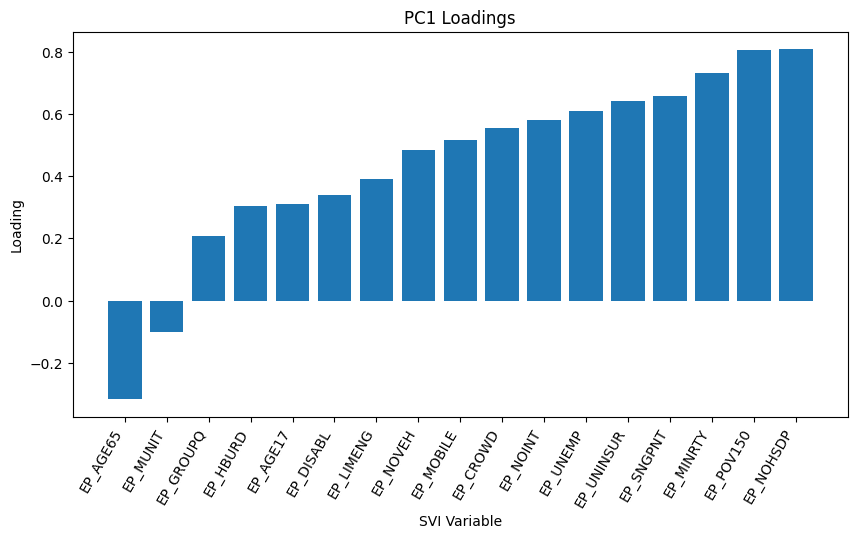

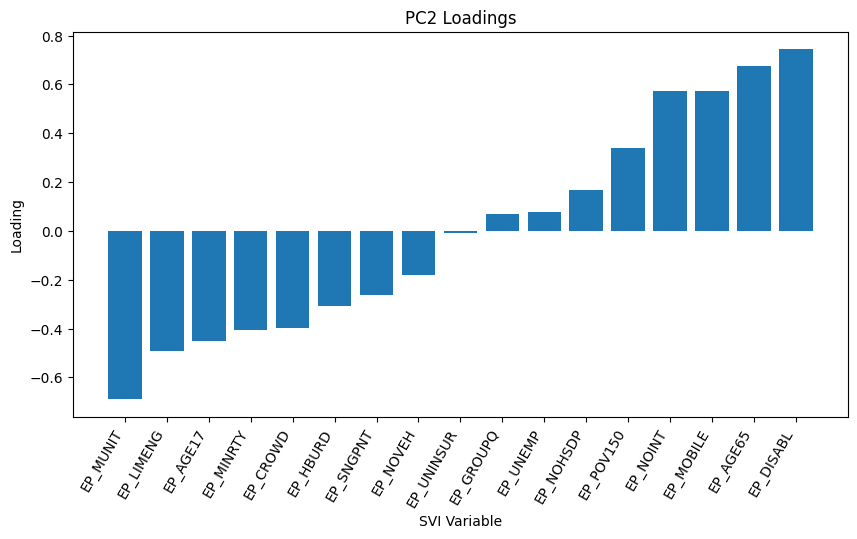

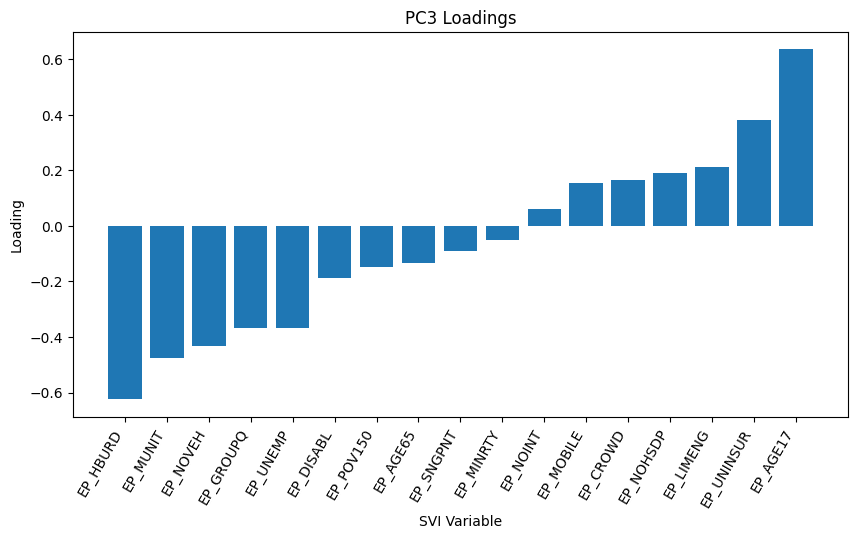

In [21]:
def plot_loadings(pc_idx):
    vals = loadings.iloc[:, pc_idx]
    order = vals.sort_values().index
    plt.figure(figsize=(10,5))
    plt.bar(range(len(SVI_VARS)), vals[order])
    plt.xticks(range(len(SVI_VARS)), order, rotation=60, ha='right')
    plt.title(f"PC{pc_idx+1} Loadings")
    plt.xlabel("SVI Variable")
    plt.ylabel("Loading")
    plt.show()

plot_loadings(0)
plot_loadings(1)
plot_loadings(2)


## PCA Scores

In [22]:
scores = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
if ID_COLS:
    scores = pd.concat([svi_clean[ID_COLS].reset_index(drop=True),
                        scores.reset_index(drop=True)], axis=1)
scores.head()


,FIPS,STATE_x,COUNTY_x,NRI_ID,PC1,PC2,PC3,PC4,PC5,PC6,...,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1001,Alabama,Autauga,C01001,-0.991040,-0.366071,0.831220,-0.481993,0.684692,0.382104,...,-0.338145,0.559996,0.299080,-0.402265,-0.422682,-0.027112,0.674901,0.188306,0.233642,-0.365447
1,1003,Alabama,Baldwin,C01003,-1.776816,-1.025103,-0.400895,0.350233,-0.460791,0.687855,...,0.251372,0.995051,0.440398,0.228677,-0.346596,-0.727630,-0.426702,0.102187,0.381530,0.616440
2,1005,Alabama,Barbour,C01005,4.461214,1.217623,-0.971670,0.754672,1.304562,-0.677016,...,-0.320425,-0.571393,0.771682,-1.350473,0.197429,0.481362,-0.273041,-0.109384,0.239005,0.469984
3,1007,Alabama,Bibb,C01007,2.113931,1.449988,-0.656709,-0.226219,1.074960,0.182073,...,-0.771856,0.739517,0.603102,0.239387,-0.048502,0.786191,-0.018834,-0.262679,0.270996,0.498634
4,1009,Alabama,Blount,C01009,0.578184,0.804139,1.149731,-0.087876,-0.037695,0.334674,...,-0.666143,0.639299,0.210763,0.128381,-0.040899,0.705282,-0.172765,-0.351656,0.131431,0.183733


## Make Map of PC1 Scores by County

Loading county shapefile...
Shapefile loaded.


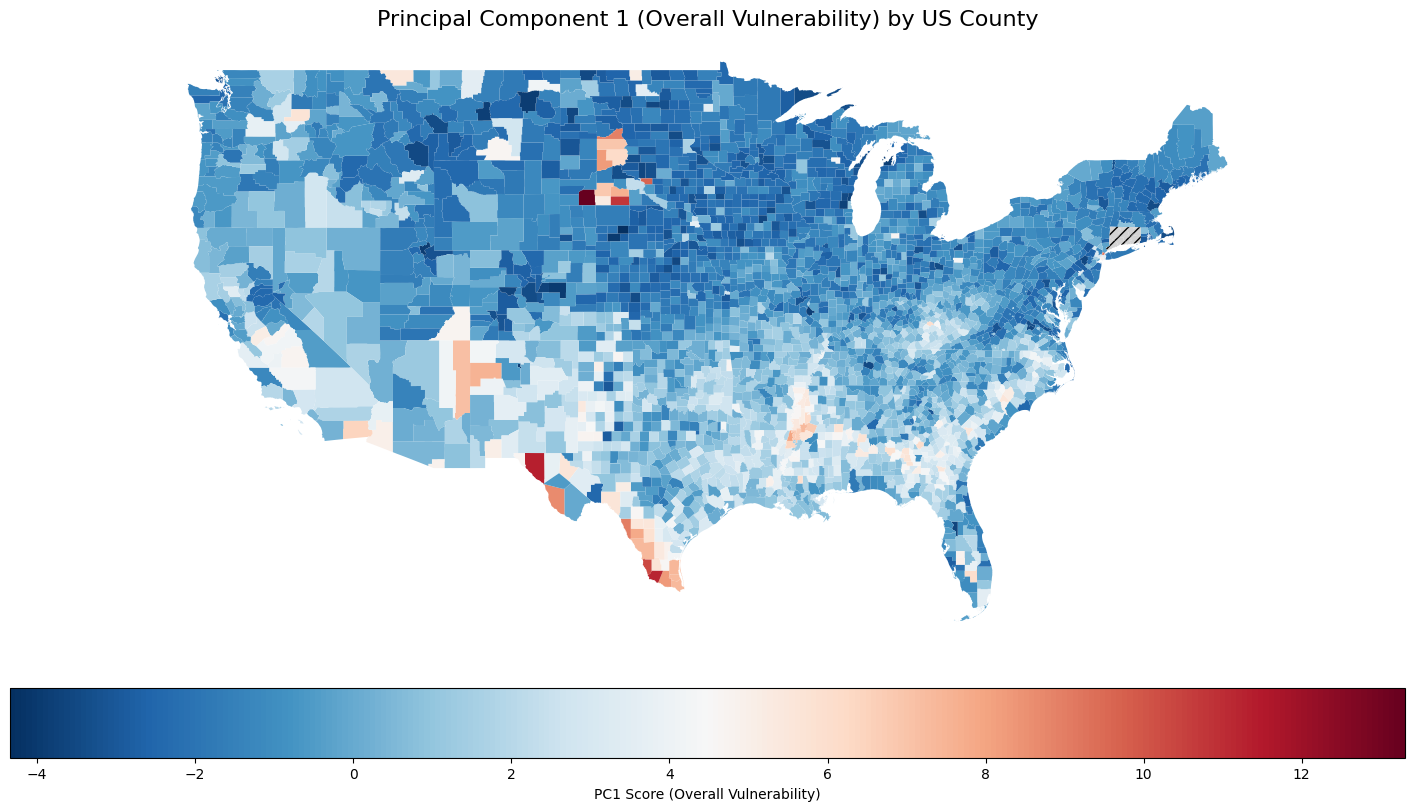

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import ssl

# --- START FIX FOR SSL ERROR ---
# This creates an unverified SSL context to bypass the certificate error.
# We do this because the environment may not have the census.gov root certificate.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python version
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# --- END FIX ---


# 1. Load US Counties Shapefile from the US Census
# This URL points to a 500k resolution shapefile zip.
SHAPEFILE_URL = "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip"
print("Loading county shapefile...")
gdf_counties = gpd.read_file(SHAPEFILE_URL)
print("Shapefile loaded.")

# 2. Prepare our 'scores' DataFrame for merging
# The FIPS codes must be 5-digit strings (e.g., '01001' for Autauga, AL)
scores_map = scores.copy()
scores_map['FIPS'] = scores_map['FIPS'].astype(str).str.zfill(5)

# 3. Prepare the GeoDataFrame for merging
# The shapefile's 'GEOID' column corresponds to FIPS.
gdf_counties['FIPS'] = gdf_counties['GEOID']

# 4. Merge your PC1 scores with the geospatial data
merged_gdf = gdf_counties.merge(scores_map, on='FIPS', how='left')

# 5. Filter for a cleaner map of the continental US (CONUS)
# This removes Alaska (02), Hawaii (15), and territories (e.g., 72=PR)
conus_gdf = merged_gdf[~merged_gdf['STATEFP'].isin([
    '02', '15', '60', '66', '69', '72', '78'
])]

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

conus_gdf.plot(
    column='PC1',       # Column to color by
    ax=ax,
    legend=True,
    legend_kwds={
        'label': "PC1 Score (Overall Vulnerability)",
        'orientation': "horizontal",
        'pad': 0.05 # Add padding
    },
    cmap='RdBu_r',      # Diverging colormap: Red = High Vuln, Blue = Low Vuln
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'none',
        'hatch': '///',
        'label': 'Missing data'
    }
)

ax.set_title('Principal Component 1 (Overall Vulnerability) by US County', fontsize=16)
ax.set_axis_off() # Remove lat/lon axes
plt.show()